In [67]:
import pandas as pd
import json

# Load JSON data
with open('./DataEngineeringQ2.json') as file:
    json_data = file.read()

# Parse JSON data
data = json.loads(json_data)

# Extract required columns from JSON data
appointments = []
for item in data:
    patient_details = item['patientDetails']
    gender = patient_details.get('gender', None)
    birth_date = patient_details.get('birthDate', None)
    appointment = {
        'appointmentId': item['appointmentId'],
        'phoneNumber': item['phoneNumber'],
        'firstName': patient_details['firstName'],
        'lastName': patient_details['lastName'],
        'gender': gender if gender in ['M', 'F'] else None,
        'DOB': birth_date,
        'medicines': item['consultationData']['medicines']
    }
    appointments.append(appointment)

# Create DataFrame from extracted data
df = pd.DataFrame(appointments)


In [68]:
df.head()

,appointmentId,phoneNumber,firstName,lastName,gender,DOB,medicines
0,40d2-9c9f,96686896670,Css,,None,None,"[{'medicineId': '619404', 'medicineName': 'A',..."
1,40dbtc9f,9496368916,Lokesh,,M,1996-05-16T18:30:00.000Z,"[{'medicineId': '619404', 'medicineName': 'A',..."
2,g3Wt5c9f,7787204833,Shila,Das,None,None,"[{'medicineId': '619404', 'medicineName': 'B',..."
3,fb6-a535,9376756879,Bhavika,Ben Panchal,F,1988-04-24T14:30:00.000Z,"[{'medicineId': '619704', 'medicineName': 'B',..."
4,67h7KL9,5267384241,Raghu Viju,,None,None,"[{'medicineId': '619384', 'medicineName': 'D',..."


In [69]:
df.columns

Index(['appointmentId', 'phoneNumber', 'firstName', 'lastName', 'gender',
       'DOB', 'medicines'],
      dtype='object')

In [70]:
df["fullName"] = df["firstName"] + " " + df["lastName"]

In [71]:
def is_valid_mobile(number):
    if number is None:
        return False
    number = str(number)
    if number.startswith("+91"):
        number = number[3:]
    elif number.startswith("91"):
        number = number[2:]
    return number.isdigit() and 6000000000 <= int(number) <= 9999999999


df["isValidMobile"] = df["phoneNumber"].apply(is_valid_mobile)

In [72]:
import hashlib
#hasing the column 
def hash_phone_number(number):
    if number is None or not is_valid_mobile(number):
        return None
    number = str(number)
    if number.startswith("+91"):
        number = number[3:]
    elif number.startswith("91"):
        number = number[2:]
    return hashlib.sha256(number.encode()).hexdigest()

df["phoneNumberHash"] = df["phoneNumber"].apply(hash_phone_number)

In [73]:
def calculate_age(birth_date):
    if birth_date is None:
        return None
    birth_date = pd.to_datetime(birth_date)
    today = pd.Timestamp.now()
    age = today.year - birth_date.year
    if (today.month, today.day) < (birth_date.month, birth_date.day):
        age -= 1
    return age

df["Age"] = df["DOB"].apply(calculate_age)

In [74]:
df['medicines'][0] # checking the medicines column details

[{'medicineId': '619404',
  'medicineName': 'A',
  'medicineNameStrengthType': '',
  'frequency': '1-0-1',
  'duration': '90',
  'durationIn': 'DAYS',
  'instruction': 'AFTER MEAL',
  'isActive': True},
 {'medicineId': '619804',
  'medicineName': 'B',
  'medicineNameStrengthType': '',
  'frequency': '1-0-1',
  'duration': '90',
  'durationIn': 'DAYS',
  'instruction': 'AFTER MEAL',
  'isActive': False}]

In [75]:
# Aggregating columns by appointmentId
df["noOfMedicines"] = df["medicines"].apply(lambda x: len(x))
df["noOfActiveMedicines"] = df["medicines"].apply(lambda x: sum(1 for med in x if med["isActive"]))
df["noOfInActiveMedicines"] = df["medicines"].apply(lambda x: sum(1 for med in x if not med["isActive"]))
df["MedicineNames"] = df["medicines"].apply(lambda x: ", ".join(med["medicineName"] for med in x if med["isActive"]))

# Remove the 'medicines' column if not needed
# df = df.drop("medicines", axis=1)


In [76]:
df_csv=df[['appointmentId','fullName','phoneNumber','isValidMobile','phoneNumberHash','gender','DOB','Age','noOfMedicines','noOfActiveMedicines','noOfInActiveMedicines','MedicineNames']]

In [77]:
df_csv.to_csv("output.csv", sep="~", index=False)
#saving in csv with "~" operator

In [78]:
df_json = df_csv.astype(object)
df_json["phoneNumber"] = df_json["phoneNumber"].astype(str) 

In [79]:
aggregated_data = {
    "Age": df_json["Age"].mean(),
    "gender": df_json["gender"].value_counts().to_dict(),
    "validPhoneNumbers": df_json["isValidMobile"].sum(),
    "appointments": len(df_json),
    "medicines": df_json["noOfMedicines"].sum(),
    "activeMedicines": df_json["noOfActiveMedicines"].sum()
}

In [80]:
with open("Aggregated_Data.json", "w") as file:
    json.dump(aggregated_data, file, indent=4)
#saving the json file

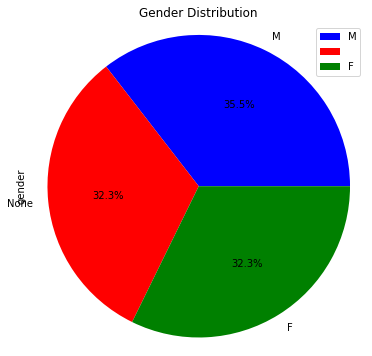

In [81]:
import matplotlib.pyplot as plt
gender_counts = df['gender'].value_counts(dropna=False)

# Plot the pie chart
plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'red', 'green'])
plt.title('Gender Distribution')
plt.legend(labels=gender_counts.index, loc='best')
plt.axis('equal')
plt.show()